# MA 195L.2 Project 1: VaR for Currencies and Bonds

## Version 1: April 25, 2021

### Instructor: Jakov Ivan S. Dumbrique (jdumbrique@ateneo.edu)

MA 195L.2: Introduction to Financial Mathematics II \
Second Semester, S.Y. 2020-2021 \
Ateneo de Manila University

# Submission Mechanics

1. Upload the complete Jupyter notebook to the appropriate submission bin in Canvas on or before **May 22, 2021 (Saturday) 11:59 PM**.
2. Make sure that your notebook is organized, well-documented and clearly-annotated.
3. Your notebook should show all the code required for Parts 1, 2, and 3. The answers for Part 2 should be displayed in your Notebook. For questions requiring some analysis/explanation (Part 3), make sure to write your detailed paragraphs (and display your graphs) in [markdown cells](https://www.tutorialspoint.com/jupyter/jupyter_notebook_markdown_cells.htm). 
4. The filename for your Jupyter notebook should follow this format: `ma195l2_[lastnameofTeamMember1]_[lastnameofTeamMember2]_Project1.ipynb`
5. Include comments (using the # symbol) in the body of your code so that it will be easier for the instructor to understand your code. For your helper functions, write a descriptive [docstring](https://www.programiz.com/python-programming/docstrings) similar to the ones below. 
6. Make sure to indicate in a markdown cell at the start of your notebook your names, as well as the names of the people you have asked help from and the online websites you have used in solving the problem. Here is an example:

Submitted by: Brian Godwin S. Lim

People I asked help from:
1. Aaron Choi

Websites I used for completing this Project:
1. https://stackoverflow.com/questions/4130922/how-to-increment-datetime-by-custom-months-in-python-without-using-library
2. https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.title.html

Project 1 has three parts:
## Part 1: Functional Implementation
In Part 1, you are tasked to create these functions:
1. `undiversified_VaR_delta_normal_fx()`
        - Returns the undiversified d-day p% VaR of a portfolio of currencies using Delta Normal Approach
        - this should have the option to implement EWMA in estimating volatilities of the exchange-rate returns
        - uses the N-day logarithmic returns in calculating N-day VaR 
2. `diversified_VaR_delta_normal_fx()`
        - Returns the diversified d-day p% VaR of a portfolio of currencies using Delta Normal Approach
        - when you want to use EWMA for an N-asset portfolio, this function will only calculate the EWMA for a two-asset portfolio
        - uses the N-day logarithmic returns in calculating N-day VaR 
3. `VaR_hs_fx()`
        - Returns the d-day p% VaR of a portfolio of currencies using Historical Simulation Approach
        - implements the normal HS method (which simulates scenarios on the return of each individual currency), not the "alternative" HS method (which runs scenarios on the returns of the entire portfolio)
4. `VaR_brw_fx()`
        - Returns the d-day p% VaR of a portfolio of currencies using Boudoukh-Richardson-Whitelaw (BRW)  Approach
        - similar to `VaR_hs_fx()`, this function implements the normal method (which simulates scenarios on the return of each individual currency), not the "alternative" method (which runs scenarios on the returns of the entire portfolio)
5. `VaR_cfm_bonds()`
        - Returns the d-day p% VaR of a portfolio of bonds using Cash Flow Mapping (CFM)
6. `undiversified_VaR_delta_normal_bonds()`
        - Returns the undiversified d-day p% VaR of a portfolio of bonds using Delta Normal Approach
7. `diversified_VaR_delta_normal_bonds()`
        - Returns the diversified d-day p% VaR of a portfolio of bonds using Delta Normal Approach
8. `VaR_hs_bonds()`
        - Returns the d-day p% VaR of a portfolio of bonds using Historical Simulation Approach

The specifications of these functions are up to the team's discretion, as long as you document them in their corresponding docstrings. You may create helper functions you can call for reusing computations.

Import the necessary packages

In [1]:
import numpy as np # Numerical Computing
import pandas as pd # Data Wrangling
import matplotlib.pyplot as plt # Plotting
import datetime as dt # Datetime
from dateutil.relativedelta import relativedelta # Changing datetime
from scipy.stats import norm # Statistical Analysis
from statistics import NormalDist # Statistical Analysis

%matplotlib inline

## Currencies 

In [2]:
def get_return_fx(df):
    return np.log(df["Mid"]/df["previous"])

def get_weights_fx(df,d,ewma_par):
    count_returns = len(df["Mid"])-d
    weight_lst = [(1-ewma_par)*(ewma_par**i) for i in range(count_returns)]
    df["weight"] = pd.Series(weight_lst)
    return df

In [3]:
def undiversified_VaR_delta_normal_fx(    
    df_lst, N_lst, d, p, 
    ewma_par_lst=None
):
    """ Returns the undiversified d-day p% VaR of a portfolio of currencies using Delta Normal Approach.
    
    Parameters
    ----------
    df_lst : list of pandas.DataFrame
        each df has two columns: (1) Date [str] and (2) Mid [float]
        assumes the dates are arranged from newest to oldest, and the date today is the date on the first row
        asssumes that all dfs have the same ordered list of dates
        there is one df per currency in the portfolio
    N_lst : list (of int)
        N_i = position for ith currency (order should be the same as the order in df_lst)
    d : int
        the value to be used in calculating the d-day VaR (e.g. 1-day, 5-day)
    p : int
        the value to be used in calculating the p% VaR (e.g. 99, 95)
    ewma_par_lst : list (of float)
        ewma_par_i = the value of the lambda parameter in an exponentially-weighted moving average model 
        for ith currency (order should be the same as the order in df_lst) 
        assumes the value is in range (0,1)
        assumes there is no None value in the list
    
    Returns
    -------
    float 
        undiversified d-day p% VaR of a portfolio of currencies using Delta Normal Approach
    """
    
    # Initialize return value 
    VaR = 0 
    
    # Process each df in df_lst
    for i in range(len(df_lst)): 
        
        # Get the closing price
        s0 = df_lst[i].loc[0,"Mid"] 
                
        # Get the return
        df_lst[i]["previous"] = df_lst[i]["Mid"].shift(-d)
        df_lst[i]["return"] = df_lst[i].apply(get_return_fx,axis=1)     
        
        if ewma_par_lst:
            # Solve for the weights and compute the standard deviation
            df_lst[i] = get_weights_fx(df_lst[i],d,ewma_par_lst[i])
            sigma = np.sqrt(np.nansum((df_lst[i]["return"]**2) * df_lst[i]["weight"]))
            
        else:
            # Get the standard deviation
            sigma = df_lst[i]["return"].std() 
        
        quantile = NormalDist().inv_cdf(p/100)
        
        VaR += abs(s0 * N_lst[i] * sigma * quantile)
    
    return VaR

In [4]:
def diversified_VaR_delta_normal_fx(
    df_lst, N_lst, d, p, 
    ewma_par_lst=None,
    covar_ewma_par_mat=None
):
    """Returns the diversified d-day p% VaR of a portfolio of currencies using Delta Normal Approach.
    
    Parameters
    ----------
    df_lst : list of pandas.DataFrame
        each df has two columns: (1) Date [str] and (2) Mid [float]
        assumes the dates are arranged from newest to oldest, and the date today is the date on the first row
        asssumes that all dfs have the same ordered list of dates
        there is one df per currency in the portfolio
    N_lst : list (of int)
        N_i = position for ith currency (order should be the same as the order in df_lst)
    d : int
        the value to be used in calculating the d-day VaR (e.g. 1-day, 5-day)
    p : int
        the value to be used in calculating the p% VaR (e.g. 99, 95)
    ewma_par_lst : list (of float)
        ewma_par_i = the value of the lambda parameter in an exponentially-weighted moving average model 
        for ith currency (order should be the same as the order in df_lst) 
        assumes the value is in range (0,1)
        assumes there is no None value in the list
    covar_ewma_par_mat : array of array
        covar_ewma_par_mat[i][j] = the EWMA decay parameter for the covariance of the returns of currency i and j
        this matrix only has value if EWMA will be used
    
    Returns
    -------
    float
        diversified d-day p% VaR of a portfolio of currencies using Delta Normal Approach
    """
    
    # Initialize arrays
    a = [0 for i in range(len(df_lst))] # alpha vector
    return_lst = [0 for i in range(len(df_lst))] # array of returns
    
    # Process each df in df_lst
    for i in range(len(df_lst)):
        
        # Compute a_i
        a[i] = N_lst[i] * df_lst[i].loc[0,"Mid"]
    
        # Get the returns
        df_lst[i]["previous"] = df_lst[i]["Mid"].shift(-d)
        df_lst[i]["return"] = df_lst[i].apply(get_return_fx,axis=1)   
        
        # Append the current list of return to return_lst
        return_lst[i] = df_lst[i]["return"][:-d]
    
    # Convert a to a numpy array
    a = np.array(a)

    if ewma_par_lst:
        # Initialize Capital Sigma (Covariance Matrix)
        SIGMA = [[0 for i in range(len(df_lst))] for j in range(len(df_lst))]
        
        # Process diagonals (Variance)
        for i in range(len(df_lst)):
            df_lst[i] = get_weights_fx(df_lst[i],d,ewma_par_lst[i])
            SIGMA[i][i] = np.nansum((df_lst[i]["return"]**2) * df_lst[i]["weight"])
        
        # Process off-diagonals (Covariance)
        df_len = len(df_lst[0]["Mid"])-d
        for i in range(len(df_lst)):
            for j in range(i+1,len(df_lst)):
                weights = np.array([(1-covar_ewma_par_mat[i][j])*(covar_ewma_par_mat[i][j]**k) for k in range(df_len)])
                tmp = df_lst[i]["return"] * df_lst[j]["return"]
                cov_ij = np.nansum(tmp[:-d] * weights)
                SIGMA[i][j] = SIGMA[j][i] = cov_ij
                
    else:
        # Get the Covariance Matrix
        SIGMA = np.cov(return_lst)
    
    # Compute the standard deviation of the portfolio
    sigma = np.sqrt(abs(np.dot(a.T,np.dot(SIGMA,a))))
        
    quantile = NormalDist().inv_cdf(p/100)
    
    VaR = abs(sigma * quantile)
        
    return VaR

In [5]:
def VaR_hs_fx(
    df_lst, N_lst, d, p
):
    """ Returns the d-day p% VaR of a portfolio of currencies using Historical Simulation Approach.
    
    Parameters
    ----------
    df_lst : list of pandas.DataFrame
        each df has two columns: (1) Date [str] and (2) Mid [float]
        assumes the dates are arranged from newest to oldest, and the date today is the date on the first row
        asssumes that all dfs have the same ordered list of dates
        there is one df per currency in the portfolio
    N_lst : list (of int)
        N_i = position for ith currency (order should be the same as the order in df_lst)
    d : int
        the value to be used in calculating the d-day VaR (e.g. 1-day, 5-day)
    p : int
        the value to be used in calculating the p% VaR (e.g. 99, 95)
       
    Returns
    -------
    float
        d-day p% VaR of a portfolio of currencies using Historical Simulation Approach    
    """
    
    # Create a df of Change in Value
    dP = df_lst[0][:-d].copy()
    dP.drop("Mid",axis=1,inplace=True)
    dP["Change in Value"] = 0
    
    for i in range(len(df_lst)):
        
        # Compute F * y_0 the current value of the ith currency
        Fy = N_lst[i] * df_lst[i].loc[0,"Mid"]
    
        # Get the returns
        df_lst[i]["previous"] = df_lst[i]["Mid"].shift(-d)
        df_lst[i]["return"] = df_lst[i].apply(get_return_fx,axis=1)   
        
        # Add the change in values from each currency
        dP["Change in Value"] += Fy * df_lst[i]["return"]
    
    
    k = int((len(dP))*(1-p/100))
    return abs(dP["Change in Value"].nsmallest(k).values[-1])  

In [6]:
def VaR_brw_fx(
     df_lst, N_lst, d, p, decay_par
):
    """ Returns the d-day p% VaR of a portfolio of currencies using BRW Approach.
    
    Parameters
    ----------
    df_lst : list of pandas.DataFrame
        each df has two columns: (1) Date [str] and (2) Mid [float]
        assumes the dates are arranged from newest to oldest, and the date today is the date on the first row
        asssumes that all dfs have the same ordered list of dates
        there is one df per currency in the portfolio
    N_lst : list (of int)
        N_i = position for ith currency (order should be the same as the order in df_lst)
    d : int
        the value to be used in calculating the d-day VaR (e.g. 1-day, 5-day)
    p : int
        the value to be used in calculating the p% VaR (e.g. 99, 95)
    decay_par : float
        the decay parameter of the BRW approach
       
    Returns
    -------
    float
        d-day p% VaR of a portfolio of currencies using BRW Approach    
    """
        
    # Create a df of Change in Value
    dP = df_lst[0][:-d].copy()
    dP.drop("Mid",axis=1,inplace=True)
    dP["Change in Value"] = 0
    
    count_returns = len(df_lst[0]["Mid"])-d

    weight_lst = [(1-decay_par)*(decay_par**i)/(1-decay_par**count_returns) for i in range(count_returns)]
    dP["weight"] = pd.Series(weight_lst)

    for i in range(len(df_lst)):
        
        # Compute F * y_0 the current value of the ith currency
        Fy = N_lst[i] * df_lst[i].loc[0,"Mid"]
    
        # Get the returns
        df_lst[i]["previous"] = df_lst[i]["Mid"].shift(-d)
        df_lst[i]["return"] = df_lst[i].apply(get_return_fx,axis=1)   
        
        # Add the change in values from each currency
        dP["Change in Value"] += Fy * df_lst[i]["return"]
    
    # Sort by Change in Values
    dP.sort_values(by="Change in Value",inplace = True)
    
    # Cumulative sum of weights
    dP["ecdf"] = dP["weight"].cumsum()

    for i in range(len(dP["ecdf"])):
        # Stop iteration after the first number greater than 1-p/100
        if dP["ecdf"].iloc[i] > (1-p/100):
            break

    VaR = np.interp(1-p/100,[dP["ecdf"].iloc[i-1],dP["ecdf"].iloc[i]],[dP["Change in Value"].iloc[i-1],dP["Change in Value"].iloc[i]])
    
    return abs(VaR)

## Bonds

In [7]:
def get_return_bonds(df):
    return np.log(df["Yield"]/df["previous"])

def get_weights_bonds(df,d,ewma_par):
    count_returns = len(df["Yield"])-d
    weight_lst = [(1-ewma_par)*(ewma_par**i) for i in range(count_returns)]
    df["weight"] = pd.Series(weight_lst)
    return df

def linear_interp(t,x,y):
    m = (y[1]-y[0])/(x[1]-x[0])
    y = y[0] + m*(t-x[0])
    return y

def get_tenor(start_date, end_date):
    day_count = (end_date - start_date).days
    tenor = day_count / 360.0
    return tenor

In [8]:
def get_bond_info(
    today, mat, FV, coupon_rate, coupon_freq, y 
):
    """ Calculates the (clean) price, modified duration, and DV01 of a coupon-bearing bond [not zero-coupon bond] 
        today using the given continuously compunded market yield. 
    
    Parameters
    ----------
    today : datetime
        the date today in '%Y-%m-%d' format
    mat : datetime
        the maturity date in '%Y-%m-%d' format
    FV : float
        the face value or par value, FV in units of currency
    coupon_rate : float
        (annual) coupon_rate
    coupon_freq : int
        the number of times coupon interest is paid in one year
    y : float
        market yield continuously compounded
           
    Returns
    -------
    list
        [Price,Modified Duration,DV01]
    """
    
    # Compute the coupon
    coupon = (coupon_rate * FV) / coupon_freq
    
    today = dt.datetime.strptime(today, '%Y-%m-%d')
    mat_date = dt.datetime.strptime(mat, '%Y-%m-%d') 
    
    # Create list of coupon dates
    # Currently only works for annual coupon payments
    coupon_dates = []
    coupon_date = mat_date
    
    while today < coupon_date:
        if coupon_freq==1:# annual
            coupon_dates.append(coupon_date)
            coupon_date = coupon_date.replace(year=coupon_date.year - 1) 

        else:
            coupon_dates.append(coupon_date)
            coupon_date = coupon_date - relativedelta(months=int(12/coupon_freq))           
    
    # Arrange coupon_dates in increasing order of dates
    coupon_dates = coupon_dates[::-1]
    
    # Create a dataframe of payment schedules
    pmt_df = pd.DataFrame({'coupon_dates':coupon_dates})
    
    pmt_df["t"] = [get_tenor(today, t) for t in pmt_df['coupon_dates']]
    
    pmt_df["cf"] = coupon
    pmt_df.loc[len(coupon_dates)-1,"cf"] += FV
    
    pmt_df["df"] = np.exp(-pmt_df["t"] * y)
    
    pmt_df["pv"] = pmt_df["cf"] * pmt_df["df"]
    
    pmt_df["mod_dur"] = pmt_df["t"] * pmt_df["pv"] / pmt_df["pv"].sum()

    Price = pmt_df["pv"].sum()
    Modified_Duration = pmt_df["mod_dur"].sum()
    DV01 = Price * Modified_Duration / 100**2
    
    return [Price, Modified_Duration, DV01]

In [9]:
def undiversified_VaR_delta_normal_bonds(    
    df_lst, N_lst, d, p, 
    ewma_par_lst=None
):
    """ Returns the undiversified d-day p% VaR of a portfolio of bonds using Delta Normal Approach.
    
    Parameters
    ----------
    df_lst : list of pandas.DataFrame
        each df has two columns: (1) Date [str] and (2) Yield [float]
        assumes the dates are arranged from newest to oldest, and the date today is the date on the first row
        asssumes that all dfs have the same ordered list of dates
        there is one df per currency in the portfolio
    N_lst : list (of float)
        N_i = NV01 for ith bond (order should be the same as the order in df_lst)
    d : int
        the value to be used in calculating the d-day VaR (e.g. 1-day, 5-day)
    p : int
        the value to be used in calculating the p% VaR (e.g. 99, 95)
    ewma_par_lst : list (of float)
        ewma_par_i = the value of the lambda parameter in an exponentially-weighted moving average model 
        for ith bond (order should be the same as the order in df_lst) 
        assumes the value is in range (0,1)
        assumes there is no None value in the list
    
    Returns
    -------
    float 
        undiversified d-day p% VaR of a portfolio of bonds using Delta Normal Approach
    """
    
    # Initialize return value 
    VaR = 0 
    
    # Process each df in df_lst
    for i in range(len(df_lst)): 
        
        # Get the closing yield
        y0 = df_lst[i].loc[0,"Yield"]/100 
                
        # Get the return
        df_lst[i]["previous"] = df_lst[i]["Yield"].shift(-d)
        df_lst[i]["return"] = df_lst[i].apply(get_return_bonds,axis=1)     
        
        if ewma_par_lst:
            # Solve for the weights and compute the standard deviation
            df_lst[i] = get_weights_bonds(df_lst[i],d,ewma_par_lst[i])
            sigma = np.sqrt(np.nansum((df_lst[i]["return"]**2) * df_lst[i]["weight"]))
            
        else:
            # Get the standard deviation
            sigma = df_lst[i]["return"].std() 
        
        quantile = NormalDist().inv_cdf(p/100)
        
        VaR += 10000 * y0 * N_lst[i] * sigma * quantile
    
    return VaR

In [10]:
def diversified_VaR_delta_normal_bonds(
    df_lst, N_lst, d, p, 
    ewma_par_lst=None,
    covar_ewma_par_mat=None
):
    """Returns the diversified d-day p% VaR of a portfolio of bonds using Delta Normal Approach.
    
    Parameters
    ----------
    df_lst : list of pandas.DataFrame
        each df has two columns: (1) Date [str] and (2) Yield [float]
        assumes the dates are arranged from newest to oldest, and the date today is the date on the first row
        asssumes that all dfs have the same ordered list of dates
        there is one df per currency in the portfolio
    N_lst : list (of int)
        N_i = NV01 for ith bond (order should be the same as the order in df_lst)
    d : int
        the value to be used in calculating the d-day VaR (e.g. 1-day, 5-day)
    p : int
        the value to be used in calculating the p% VaR (e.g. 99, 95)
    ewma_par_lst : list (of float)
        ewma_par_i = the value of the lambda parameter in an exponentially-weighted moving average model 
        for ith bond (order should be the same as the order in df_lst) 
        assumes the value is in range (0,1)
        assumes there is no None value in the list
    covar_ewma_par_mat : array of array
        covar_ewma_par_mat[i][j] = the EWMA decay parameter for the covariance of the returns of currency i and j
        this matrix only has value if EWMA will be used
    
    Returns
    -------
    float
        diversified d-day p% VaR of a portfolio of bonds using Delta Normal Approach
    """
        
    # Initialize arrays
    a = [0 for i in range(len(df_lst))] # alpha vector
    return_lst = [0 for i in range(len(df_lst))] # array of returns
    
    # Process each df in df_lst
    for i in range(len(df_lst)):
        
        # Compute a_i
        a[i] = -10000 * N_lst[i] * df_lst[i].loc[0,"Yield"]/100
    
        # Get the returns
        df_lst[i]["previous"] = df_lst[i]["Yield"].shift(-d)
        df_lst[i]["return"] = df_lst[i].apply(get_return_bonds,axis=1)   
        
        # Append the current list of return to return_lst
        return_lst[i] = df_lst[i]["return"][:-d]
    
    # Convert a to a numpy array
    a = np.array(a)

    if ewma_par_lst:
        # Initialize Capital Sigma (Covariance Matrix)
        SIGMA = [[0 for i in range(len(df_lst))] for j in range(len(df_lst))]
        
        # Process diagonals (Variance)
        for i in range(len(df_lst)):
            df_lst[i] = get_weights_bonds(df_lst[i],d,ewma_par_lst[i])
            SIGMA[i][i] = np.nansum((df_lst[i]["return"]**2) * df_lst[i]["weight"])
        
        # Process off-diagonals (Covariance)
        df_len = len(df_lst[0]["Yield"])-d
        for i in range(len(df_lst)):
            for j in range(i+1,len(df_lst)):
                weights = np.array([(1-covar_ewma_par_mat[i][j])*(covar_ewma_par_mat[i][j]**k) for k in range(df_len)])
                tmp = df_lst[i]["return"] * df_lst[j]["return"]
                cov_ij = np.nansum(tmp[:-d] * weights)
                SIGMA[i][j] = SIGMA[j][i] = cov_ij

    else:
        # Get the Covariance Matrix
        SIGMA = np.cov(return_lst)
    
    # Compute the standard deviation of the portfolio
    sigma = np.sqrt(np.dot(a.T,np.dot(SIGMA,a)))
        
    quantile = NormalDist().inv_cdf(p/100)
    
    VaR = sigma * quantile
        
    return VaR

In [11]:
def VaR_hs_bonds(
    zero_rate_data,today, mat, FV, coupon_rate, coupon_freq, d, p
):
    """ Returns the d-day p% VaR of a bond using Historical Simulation Approach.
    
    Parameters
    ----------
    zero_rate_data : pandas.DataFrame
        the historical zero rates for the benchmark tenors
    today : datetime
        the date today in '%Y-%m-%d' format
    mat : datetime
        the maturity date in '%Y-%m-%d' format
    FV : float
        the face value or par value, FV in units of currency
    coupon_rate : float
        (annual) coupon_rate
    coupon_freq : int
        the number of times coupon interest is paid in one year
    d : int
        the value to be used in calculating the d-day VaR (e.g. 1-day, 5-day)
    p : int
        the value to be used in calculating the p% VaR (e.g. 99, 95)
       
    Returns
    -------
    float
        d-day p% VaR of a bond using Historical Simulation Approach    
    """
    
    # Create empty dictionary for renaming
    rename_dict = {}
    
    # Create empty list for storing tenors of benchmark
    tenor = []
    
    # Process the columns
    for i in zero_rate_data.columns:
        if len(str(i).split("-")) == 2:
            [a,b] = str(i).split("-")
            a = int(a)
            if b == "Month":
                rename_dict[i] = a/12
                tenor.append(a/12)
            elif b == "Year":
                rename_dict[i] = a
                tenor.append(a)
                
    # Convert the labels to floats
    zero_rate_data.rename(rename_dict,axis=1,inplace=True)
        
    # Compute the coupon
    coupon = (coupon_rate * FV) / coupon_freq
    
    today = dt.datetime.strptime(today, '%Y-%m-%d')
    mat_date = dt.datetime.strptime(mat, '%Y-%m-%d') 
    
    # Create list of coupon dates
    # Currently only works for annual coupon payments
    coupon_dates = []
    coupon_date = mat_date
    
    while today < coupon_date:
        if coupon_freq==1:# annual
            coupon_dates.append(coupon_date)
            coupon_date = coupon_date.replace(year=coupon_date.year - 1) 

        else:
            coupon_dates.append(coupon_date)
            coupon_date = coupon_date - relativedelta(months=int(12/coupon_freq))
    
    # Arrange coupon_dates in increasing order of dates
    coupon_dates = coupon_dates[::-1]
    
    # Create a dataframe of payment schedules
    pmt_df = pd.DataFrame({'coupon_dates':coupon_dates})
    
    pmt_df["t"] = [get_tenor(today, t) for t in pmt_df['coupon_dates']]
    
    pmt_df["cf"] = coupon
    pmt_df.loc[len(coupon_dates)-1,"cf"] += FV
    
    for t in pmt_df["t"]:
        idx = 0
        
        # Get the two nearest tenors from the benchmark data
        while tenor[idx] < t and idx < len(tenor):
            idx += 1
        
        # Linearly interpolate to get the desired tenor
        zero_rate_data[t] = linear_interp(t, [tenor[idx],tenor[idx-1]],
                                           [zero_rate_data[tenor[idx]],zero_rate_data[tenor[idx-1]]] )

    # Generate the DataFrames needed
    possible_returns = pd.DataFrame({"Date":zero_rate_data["Date"][:-d]})
    possible_zero_rate = pd.DataFrame({"Date":zero_rate_data["Date"][:-d]})
    possible_df = pd.DataFrame({"Date":zero_rate_data["Date"][:-d]})
    possible_prices = pd.DataFrame({"Date":zero_rate_data["Date"][:-d],"Price":0})
        
    for t in pmt_df["t"]:
        # Create a temporary DataFrame
        tmp_df = pd.DataFrame({"Date":zero_rate_data["Date"]})
        
        # Copy the Yield for tenor t
        tmp_df["Yield"] = zero_rate_data[t]
        
        # Get the returns
        tmp_df["previous"] = tmp_df["Yield"].shift(-d)
        tmp_df["return"] = tmp_df.apply(get_return_bonds,axis=1)   
        
        # Get the current yield 
        y0 = tmp_df["Yield"].iloc[0]
        
        # Add the results to the corresponding DataFrames
        possible_returns[t] = tmp_df["return"][:-d]
        possible_zero_rate[t] = y0 * np.exp(tmp_df["return"][:-d])
        possible_df[t] = np.exp(- possible_zero_rate[t] * t)

    # For all tenors
    for i in range(len(pmt_df["t"])):
        t = pmt_df["t"].iloc[i]
        cf = pmt_df["cf"].iloc[i]
        
        # Add the PV
        possible_prices["Price"] +=  cf * possible_df[t]
    
    # Compute P0
    P0 = possible_prices["Price"].iloc[0]
    
    k = int((len(possible_prices))*(1-p/100))
    
    return abs(possible_prices["Price"].nsmallest(k).values[-1]-P0)  

In [12]:
def VaR_cfm_bonds(
    zero_rate_data,today, mat, FV, coupon_rate, coupon_freq, d, p
):     
    """ Returns the d-day p% VaR of a bond using Cash Flow Mapping (CFM).
    
    Parameters
    ----------
    zero_rate_data : pandas.DataFrame
        the historical zero rates for the benchmark tenors
    today : datetime
        the date today in '%Y-%m-%d' format
    mat : datetime
        the maturity date in '%Y-%m-%d' format
    FV : float
        the face value or par value, FV in units of currency
    coupon_rate : float
        (annual) coupon_rate
    coupon_freq : int
        the number of times coupon interest is paid in one year
    d : int
        the value to be used in calculating the d-day VaR (e.g. 1-day, 5-day)
    p : int
        the value to be used in calculating the p% VaR (e.g. 99, 95)
       
    Returns
    -------
    float
        d-day p% VaR of a bond using Cash Flow Mapping    
    """
    
    # Create empty dictionary for renaming
    rename_dict = {}
    
    # Create empty list for storing tenors of benchmark
    tenor = []
    
    # Process the columns
    for i in zero_rate_data.columns:
        if len(str(i).split("-")) == 2:
            [a,b] = str(i).split("-")
            a = int(a)
            if b == "Month":
                rename_dict[i] = a/12
                tenor.append(a/12)
            elif b == "Year":
                rename_dict[i] = a
                tenor.append(a)
                
    # Convert the labels to floats
    zero_rate_data.rename(rename_dict,axis=1,inplace=True)
        
    # Compute the coupon
    coupon = (coupon_rate * FV) / coupon_freq
    
    today = dt.datetime.strptime(today, '%Y-%m-%d')
    mat_date = dt.datetime.strptime(mat, '%Y-%m-%d') 
    
    # Create list of coupon dates
    # Currently only works for annual coupon payments
    coupon_dates = []
    coupon_date = mat_date
    
    while today < coupon_date:
        if coupon_freq==1:# annual
            coupon_dates.append(coupon_date)
            coupon_date = coupon_date.replace(year=coupon_date.year - 1) 

        else:
            coupon_dates.append(coupon_date)
            coupon_date = coupon_date - relativedelta(months=int(12/coupon_freq))

    # Arrange coupon_dates in increasing order of dates
    coupon_dates = coupon_dates[::-1]
    
    # Create a dataframe of payment schedules
    pmt_df = pd.DataFrame({'coupon_dates':coupon_dates})
    
    pmt_df["t"] = [get_tenor(today, t) for t in pmt_df['coupon_dates']]
    
    pmt_df["cf"] = coupon
    pmt_df.loc[len(coupon_dates)-1,"cf"] += FV
    
    # Generate the DataFrame of N-day returns
    returns_df = pd.DataFrame({"Date":zero_rate_data["Date"][:-d]})
    
    for t in zero_rate_data.columns:
        if t == "Date":
            continue
        
        # Create a temporary DataFrame
        tmp_df = pd.DataFrame({"Date":zero_rate_data["Date"]})
        
        # Copy the Yield for tenor t
        tmp_df["Yield"] = zero_rate_data[t]
        
        # Get the returns
        tmp_df["previous"] = tmp_df["Yield"].shift(-d)
        tmp_df["return"] = tmp_df.apply(get_return_bonds,axis=1)   
                
        # Add the results to the corresponding DataFrames
        returns_df[t] = tmp_df["return"][:-d]    
    
    # Output df
    tmp = returns_df.copy()
    tmp.rename({1/12:round(1/12,3)},axis=1,inplace=True)
    
    # Compute the correlation matrix
    corr_mat = returns_df.corr()
    print("The correlation matrix is:")
    print(round(tmp.corr(),2))
    print("")
    
    # Compute the standard deviation of each tenor
    std_lst = returns_df.std()
    print("The volatilities are:")
    print(round(tmp.std(),2))
    print("")
    
    # Compute the covariance matrix
    SIGMA = returns_df.cov()
        
    # Initialize the cash flow map
    cf_map = pd.DataFrame(data=[np.zeros(len(tenor))],columns=tenor)   
    
    # Map each cash flow
    for i in range(len(pmt_df["t"])):
        cf = pmt_df["cf"].iloc[i]
        t = pmt_df["t"].iloc[i]
        idx = 0
        
        # Get the two nearest tenors from the benchmark data
        while tenor[idx] < t and idx < len(tenor):
            idx += 1
        
        # Assign the variables
        t1 = tenor[idx-1]
        t2 = tenor[idx]
        sigma1 = std_lst.loc[t1]
        sigma2 = std_lst.loc[t2]
        rho = corr_mat.loc[t1,t2]
        sigma = linear_interp(t,[t1,t2],[sigma1,sigma2])
        y0 = linear_interp(t,[t1,t2],[zero_rate_data[t1].iloc[0],zero_rate_data[t2].iloc[0]])

        # Compute alpha1 and alpha2  
        A = sigma1**2 + sigma2**2 - 2*rho*sigma1*sigma2
        B = 2*rho*sigma1*sigma2 - 2*sigma2**2
        C = sigma2**2 - sigma**2
        
        alpha1 = (-B + np.sqrt(B**2 - 4*A*C)) / (2*A)
        if (alpha1 > 1) or (alpha1 < 0):
            alpha1 = (-B - np.sqrt(B**2 - 4*A*C)) / (2*A)
            
        alpha2 = 1 - alpha1
        
        print("For cash flow "+str(int(i+1))+" worth "+str(round(cf,2))+", the alphas are: "+str(round(alpha1,2))+" and "+str(round(alpha2,2))+".")
        
        # Add the values to the tenor
        cf_map[t1] += alpha1 * cf * np.exp(- zero_rate_data[t1].iloc[0] * t1 )
        cf_map[t2] += alpha2 * cf * np.exp(- zero_rate_data[t2].iloc[0] * t2 )
    
    print("")
    
    print("The present value of the cash flows are:")
    print(round(cf_map,2))
    
    print("")
    
    # Compute the standard deviation
    alpha = cf_map.copy();
    
    sigma = np.sqrt(np.dot(cf_map,np.dot(SIGMA,cf_map.T)))
    quantile = NormalDist().inv_cdf(p/100)
    
    return sigma[0][0] * quantile

# Part 2: Validation
In Part 2, you will be using the functions you created in Part 1 to answer the following questions. The historical data for these items can be found in the `data` folder of our [class Github repository](https://github.com/ateneobsamf2021/ma195l2). The historical data for currencies cover the trading period from April 22, 2011 to April 23, 2021.

Assume that today is April 23, 2021. You are a portfolio risk manager who is assigned to analyze the market risk associated to the following portfolios of currencies and bonds:

<table>
    <tr>
        <td>
            Portfolio
        </td>
        <td>
            USD
        </td>
        <td>
            EUR
        </td>
        <td>
            JPY
        </td>
        <td>
            GBP
        </td>
        <td>
            CHF
        </td>  
    </tr>
        <tr>
        <td>
            Position
        </td>
        <td>
            long
        </td>
        <td>
            short
        </td>
        <td>
            long
        </td>
        <td>
            short
        </td>
        <td>
            long
        </td>
    </tr>
        <tr>
        <td>
            A
        </td>
        <td>
            10,362
        </td>
        <td>
            17,135
        </td>
        <td>
            2,235,292
        </td>
        <td>
            14,937
        </td>
        <td>
            9,465
        </td>
    </tr>
        <tr>
        <td>
            B
        </td>
        <td>
            -
        </td>
        <td>
            17,135
        </td>
        <td>
            2,235,292
        </td>
        <td>
            -
        </td>
        <td>
            -
        </td>  
    </tr>
</table>

## Question A

Suppose market risk metrics are requested for **Portfolio A**.

1. Calculate the undiversified and diversified one-day 99% VaR for the portfolio using the delta-normal approach. 
2. Use the historical simulation approach to compute the portfolio's one-day 99% VaR.
3. Use the BRW approach with a decay factor of $\lambda$= 0.85 to calculate the portfolio's one-day 99% VaR.

In [13]:
EURUSD = pd.read_csv('https://raw.githubusercontent.com/ateneobsamf2021/ma195l2/main/data/Project1/EURUSD.csv')[:2611]
GBPUSD = pd.read_csv('https://raw.githubusercontent.com/ateneobsamf2021/ma195l2/main/data/Project1/GBPUSD.csv')[:2611]
USDCHF = pd.read_csv('https://raw.githubusercontent.com/ateneobsamf2021/ma195l2/main/data/Project1/USDCHF.csv')[:2611]
USDJPY = pd.read_csv('https://raw.githubusercontent.com/ateneobsamf2021/ma195l2/main/data/Project1/USDJPY.csv')[:2611]
USDPHP = pd.read_csv('https://raw.githubusercontent.com/ateneobsamf2021/ma195l2/main/data/Project1/USDPHP.csv')[:2611]

USD = USDPHP.copy()
EUR = EURUSD.copy()
EUR["Mid"] = EURUSD["Mid"]*USDPHP["Mid"]
JPY = USDJPY.copy()
JPY["Mid"] = USDPHP["Mid"]/USDJPY["Mid"]
GBP = GBPUSD.copy()
GBP["Mid"] = GBPUSD["Mid"]*USDPHP["Mid"]
CHF = USDCHF.copy()
CHF["Mid"] = USDPHP["Mid"]*USDCHF["Mid"]

df_lst = [USD,EUR,JPY,GBP,CHF]
N_lst = [10362,-17135,2235292,-14937,9465]

undiv = undiversified_VaR_delta_normal_fx(df_lst, N_lst, 1, 99)
div = diversified_VaR_delta_normal_fx(df_lst, N_lst, 1, 99)
hs = VaR_hs_fx(df_lst, N_lst, 1, 99)
brw = VaR_brw_fx(df_lst, N_lst, 1, 99, 0.85)

print("The Undiversified 1-day 99% VaR is Php "+str(round(undiv,2))+".")
print("The Diversified 1-day 99% VaR is Php "+str(round(div,2))+".")
print("The 1-day 99% VaR using Historical Simulation is Php "+str(round(hs,2))+".")
print("The 1-day 99% VaR using BRW Approach is Php "+str(round(brw,2))+".")

The Undiversified 1-day 99% VaR is Php 52494.87.
The Diversified 1-day 99% VaR is Php 22999.72.
The 1-day 99% VaR using Historical Simulation is Php 24631.6.
The 1-day 99% VaR using BRW Approach is Php 12991.56.


## Question B

We now look at the value-at-risk metrics for **Portfolio B**.

Assume that the five-day volatility of each currency and the covariance of their returns follow exponentially weighted moving average models with the following decay parameters:

<table>
    <tr>
        <td>
           Data
        </td>
        <td>
            EUR
        </td>
        <td>
            JPY
        </td>
        <td>
            Covariance
        </td>
    </tr>
        <tr>
        <td>
            Decay Parameter
        </td>
        <td>
            0.87
        </td>
        <td>
            0.90
        </td>
        <td>
            0.95
        </td>
    </tr>
</table>

Determine the undiversified and diversified five-day 95\% VaR for the portfolio. What is the benefit of diversification?

In [14]:
EURUSD = pd.read_csv('https://raw.githubusercontent.com/ateneobsamf2021/ma195l2/main/data/Project1/EURUSD.csv')[:2611]
USDJPY = pd.read_csv('https://raw.githubusercontent.com/ateneobsamf2021/ma195l2/main/data/Project1/USDJPY.csv')[:2611]
USDPHP = pd.read_csv('https://raw.githubusercontent.com/ateneobsamf2021/ma195l2/main/data/Project1/USDPHP.csv')[:2611]

EUR = EURUSD.copy()
EUR["Mid"] = EURUSD["Mid"]*USDPHP["Mid"]
JPY = USDJPY.copy()
JPY["Mid"] = USDPHP["Mid"]/USDJPY["Mid"]

df_lst = [EUR,JPY]
N_lst = [-17135,2235292]

undiv = undiversified_VaR_delta_normal_fx(df_lst, N_lst, 5, 95,ewma_par_lst=[0.87,0.9])
div = diversified_VaR_delta_normal_fx(df_lst, N_lst, 5, 95,ewma_par_lst=[0.87,0.9],covar_ewma_par_mat=[[0,0.95],[0.95,0]])
benefit = undiv - div

print("The Undiversified 5-day 95% VaR is Php "+str(round(undiv,2))+".")
print("The Diversified 5-day 95% VaR is Php "+str(round(div,2))+".")
print("The benenfit of diversification is Php "+str(round(benefit,2))+".")

The Undiversified 5-day 95% VaR is Php 24082.23.
The Diversified 5-day 95% VaR is Php 5106.55.
The benenfit of diversification is Php 18975.68.


 
## Question C
Assume that today is April 23, 2021. Suppose market risk metrics are requested for **Portfolio C** consisting of long positions on the following four bonds:

1. Roquefort Bond
    - A corporate bond with Php 1,000,000 face value, 8% p.a. coupon rate that pays interest annually, with maturity date on December 31, 2026.
    
2. Camembert Bond
    - A corporate bond  with Php 1,000,000 face value, 7.5% p.a. coupon rate that pays interest semiannually, with maturity date on June 1, 2022.

3. Feta Bond
    - A T-bond with Php 1,000,000 face value, 6% p.a. coupon rate that pays interest quarterly, with maturity date on January 15, 2035.
    
4. Gouda Bond
    - A zero-coupon bond with Php 1,000,000 face value, with maturity date on September 28, 2030.
    

The historical **continuously-compounded** market yields for the four bonds can be found in the `portfolio_c_yield_data.csv` file. Assume an actual/360 day-count convention. 


1. Determine the dollar duration (DV01) for each bond.
2. Calculate the portfolio's undiversified and diversified 10-day 99% VaR using Delta-Normal Approach. What is the benefit of diversification?   
4. Consider the subportfolio consisting only of Roquefort Bond and Camembert Bond. Assume that the ten-day bond volatilities and the covariance of their returns follow exponentially weighted moving average models with the following decay parameters:

<table>
    <tr>
        <td>
           Data
        </td>
        <td>
            Roquefort
        </td>
        <td>
            Camembert
        </td>
        <td>
            Covariance
        </td>
    </tr>
        <tr>
        <td>
            Decay Parameter
        </td>
        <td>
            0.85
        </td>
        <td>
            0.80
        </td>
        <td>
            0.975
        </td>
    </tr>
</table>

   Determine the undiversified and diversified 10-day 99\% VaR for the subportfolio. What is the benefit of diversification?  

In [15]:
df = pd.read_csv("https://raw.githubusercontent.com/ateneobsamf2021/ma195l2/main/data/Project1/portfolio_c_yield_data.csv")
df_lst = []
N_lst = []
mat = ["2026-12-31","2022-06-01","2035-01-15","2030-09-28"]
FV = [1000000,1000000,1000000,1000000]
coupon_rate = [0.08,0.075,0.06,0]
coupon_freq = [1,2,4,1]
today="2021-04-23"

for idx in range(len(df.columns)):
    bond = df.columns[idx]
    if bond != "Date":
        tmp_df = df.copy()
        tmp_df.rename({bond:"Yield"},axis=1,inplace=True)
        df_lst.append(tmp_df)
        y = tmp_df["Yield"].iloc[0]/100
        DV01 = get_bond_info(today, mat[idx-1], FV[idx-1], coupon_rate[idx-1], coupon_freq[idx-1], y)[2]
        N_lst.append(DV01)
        print("The DV01 for "+str(bond)+" is Php "+str(round(DV01,2))+".")

print("")
        
undiv = undiversified_VaR_delta_normal_bonds(df_lst, N_lst, 10, 99)
div = diversified_VaR_delta_normal_bonds(df_lst, N_lst, 10, 99)
benefit = undiv-div
print("The Undiversified 10-day 99% VaR is Php "+str(round(undiv,2))+".")
print("The Diversified 10-day 99% VaR is Php "+str(round(div,2))+".")
print("The benefit of diversification is Php "+str(round(benefit,2))+".")

print("")

undiv = undiversified_VaR_delta_normal_bonds(df_lst[:2], N_lst[:2], 10, 99,ewma_par_lst=[0.85,0.8])
div = diversified_VaR_delta_normal_bonds(df_lst[:2], N_lst[:2], 10, 99,ewma_par_lst=[0.85,0.8],covar_ewma_par_mat=[[0,0.975],[0.975,0]])
benefit = undiv-div
print("The Undiversified 10-day 99% VaR of the subportfolio is Php "+str(round(undiv,2))+".")
print("The Diversified 10-day 99% VaR of the subportfolio is Php "+str(round(div,2))+".")
print("The benefit of diversification of the subportfolio is Php "+str(round(benefit,2))+".")


The DV01 for Roquefort is Php 484.41.
The DV01 for Camembert is Php 109.67.
The DV01 for Feta is Php 923.93.
The DV01 for Gouda is Php 720.2.

The Undiversified 10-day 99% VaR is Php 47810.4.
The Diversified 10-day 99% VaR is Php 46164.02.
The benefit of diversification is Php 1646.38.

The Undiversified 10-day 99% VaR of the subportfolio is Php 10717.56.
The Diversified 10-day 99% VaR of the subportfolio is Php 10295.13.
The benefit of diversification of the subportfolio is Php 422.43.


## Question D
Assume that today is April 23, 2021. Suppose market risk metrics are requested for **Portfolio D** consisting solely of a peso-denominated bond corporate bond with a principal of Php 10,000,000 and with maturity date on December 31, 2024. Suppose that the bond provides a coupon of 10% per annum payable semiannually.

The historical continuously-compounded zero rates for benchmark tenors are provided in the `portfolio_d_zero_rate_data.csv` file.

### Historical Simulation Approach
1. Generate possible zero rates 10 days from now for the relevant tenors and determine the portfolio's 10-day 99% VaR using the historical simulation approach.


In [16]:
zero_rates = pd.read_csv("https://raw.githubusercontent.com/ateneobsamf2021/ma195l2/main/data/Project1/portfolio_d_zero_rate_data.csv")

hs = VaR_hs_bonds(
    zero_rates,
    today="2021-04-23", 
    mat="2024-12-31", 
    FV=10000000, 
    coupon_rate=0.10, 
    coupon_freq=2,
    d = 10, 
    p = 99
)

print("The portfolio's 10-day 99% VaR is Php "+str(round(hs,2))+".")

The portfolio's 10-day 99% VaR is Php 273088.82.


### Cash Flow Mapping
1. Estimate the volatilities and correlations of zero-coupon bonds maturing on the benchmark tenors using the given data. Print out the volatilities and the correlation matrix.
2. Map the portfolio's cash flows to the benchmark tenors/standard buckets. Print out the weight $\alpha_i$ for each cash flow.
2. Print out the present values of the mapped cash flows at each benchmark tenor/standard bucket.
3. Determine the portfolio's 10-day 99% VaR. 

In [17]:
zero_rates = pd.read_csv("https://raw.githubusercontent.com/ateneobsamf2021/ma195l2/main/data/Project1/portfolio_d_zero_rate_data.csv")

hs = VaR_cfm_bonds(
    zero_rates,
    today="2021-04-23", 
    mat="2024-12-31", 
    FV=10000000, 
    coupon_rate=0.10, 
    coupon_freq=2,
    d = 10, 
    p = 99
)

print("The portfolio's 10-day 99% VaR is Php "+str(round(hs,2))+".")

The correlation matrix is:
       0.083  0.25   0.5     1     2     3     4     5
0.083   1.00  0.27  0.13  0.04 -0.01  0.01 -0.06 -0.11
0.25    0.27  1.00  0.42  0.25  0.30  0.26  0.23  0.21
0.5     0.13  0.42  1.00  0.50  0.49  0.36  0.50  0.42
1       0.04  0.25  0.50  1.00  0.37  0.29  0.30  0.37
2      -0.01  0.30  0.49  0.37  1.00  0.70  0.64  0.76
3       0.01  0.26  0.36  0.29  0.70  1.00  0.60  0.63
4      -0.06  0.23  0.50  0.30  0.64  0.60  1.00  0.69
5      -0.11  0.21  0.42  0.37  0.76  0.63  0.69  1.00

The volatilities are:
0.083    0.11
0.25     0.07
0.5      0.06
1        0.06
2        0.05
3        0.05
4        0.07
5        0.07
dtype: float64

For cash flow 1 worth 500000.0, the alphas are: 0.71 and 0.29.
For cash flow 2 worth 500000.0, the alphas are: 0.07 and 0.93.
For cash flow 3 worth 500000.0, the alphas are: 0.96 and 0.04.
For cash flow 4 worth 500000.0, the alphas are: 0.84 and 0.16.
For cash flow 5 worth 500000.0, the alphas are: 0.98 and 0.02.
For cash flo

# Part 3: Analysis

For Part 3, you will analyze the effect of changing various parameters to the resulting Value-at-Risk of a portfolio.

## Question A on Currencies

Consider **Portfolio A**. Explore, analyze, **and** discuss the effect of changing the following parameters in the resulting VaR of **each of the three methods** (Delta-Normal, HS, BRW):
1. confidence level 
2. value of N for N-day VaR
3. time window of historical data used to calculate VaR
4. decay parameter for BRW Approach

Based on your sensitivity analysis, which of the three methods would best capture the market risk of the portfolio? Justify your choice. 

### Confidence Level
Based on the graphs below, changing the confidence level only slightly affects the VaR using the Delta-Normal and Historical Simulation Approach. The graphs are _smooth_ and relatively predictable. In the Delta-Normal Approach, only the inverse cdf changes while the others remain constant. In the Historical Simulation Approach, it finds the next historical value in the lower tail of the distribution. But since each historical value are equally weighted, it is still relatively predicatable.  

On the other hand, changing the confidence level of the BRW Approach significantly affected the VaR. Similar to the Historical Simulation Approach, it finds the next historical value in the lower tail of the distribution. But since the weights assigned are different, the results will not be predictable. Moreover, since the VaR's are linearly interpolated, the results are dependent on the two nearest historical prices of the currency. Thus, the graph appears like a piecewise functions of lines.

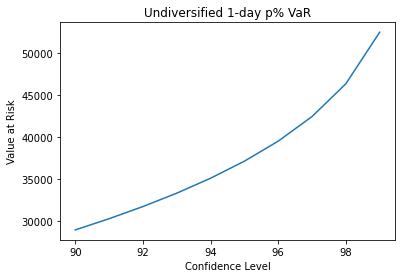

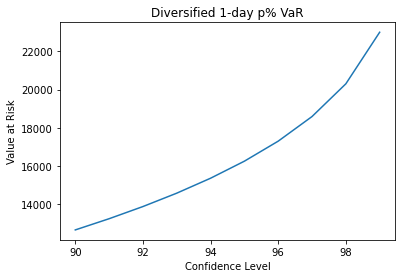

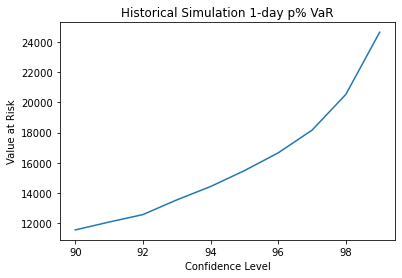

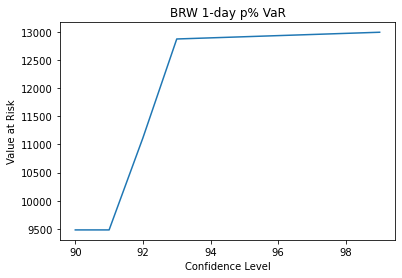

In [18]:
EURUSD = pd.read_csv('https://raw.githubusercontent.com/ateneobsamf2021/ma195l2/main/data/Project1/EURUSD.csv')[:2611]
GBPUSD = pd.read_csv('https://raw.githubusercontent.com/ateneobsamf2021/ma195l2/main/data/Project1/GBPUSD.csv')[:2611]
USDCHF = pd.read_csv('https://raw.githubusercontent.com/ateneobsamf2021/ma195l2/main/data/Project1/USDCHF.csv')[:2611]
USDJPY = pd.read_csv('https://raw.githubusercontent.com/ateneobsamf2021/ma195l2/main/data/Project1/USDJPY.csv')[:2611]
USDPHP = pd.read_csv('https://raw.githubusercontent.com/ateneobsamf2021/ma195l2/main/data/Project1/USDPHP.csv')[:2611]

USD = USDPHP.copy()
EUR = EURUSD.copy()
EUR["Mid"] = EURUSD["Mid"]*USDPHP["Mid"]
JPY = USDJPY.copy()
JPY["Mid"] = USDPHP["Mid"]/USDJPY["Mid"]
GBP = GBPUSD.copy()
GBP["Mid"] = GBPUSD["Mid"]*USDPHP["Mid"]
CHF = USDCHF.copy()
CHF["Mid"] = USDPHP["Mid"]*USDCHF["Mid"]

df_lst = [USD,EUR,JPY,GBP,CHF]
N_lst = [10362,-17135,2235292,-14937,9465]

x = range(90,100)

# Undiversified VaR
y = []
for p in x:
    undiv = undiversified_VaR_delta_normal_fx(df_lst, N_lst, 1, p)
    y.append(undiv)
plt.plot(x,y)
plt.title("Undiversified 1-day p% VaR")
plt.xlabel("Confidence Level")
plt.ylabel("Value at Risk")
plt.show()

# Diversified VaR
y = []
for p in x:
    div = diversified_VaR_delta_normal_fx(df_lst, N_lst, 1, p)
    y.append(div)
plt.plot(x,y)
plt.title("Diversified 1-day p% VaR")
plt.xlabel("Confidence Level")
plt.ylabel("Value at Risk")
plt.show()

# Historical Simulation VaR
y = []
for p in x:
    hs = VaR_hs_fx(df_lst, N_lst, 1, p)
    y.append(hs)
plt.plot(x,y)
plt.title("Historical Simulation 1-day p% VaR")
plt.xlabel("Confidence Level")
plt.ylabel("Value at Risk")
plt.show()

# BRW VaR
y = []
for p in x:
    brw = VaR_brw_fx(df_lst, N_lst, 1, p, 0.85)
    y.append(brw)
plt.plot(x,y)
plt.title("BRW 1-day p% VaR")
plt.xlabel("Confidence Level")
plt.ylabel("Value at Risk")
plt.show()

### N-day VaR
Based on the graphs below, changing the N in the N-day VaR also only slightly affects the VaR using the Delta-Normal and Historical Simulation Approach. Their graphs are concave and _smooth_. In the Delta-Normal Approach, only the inverse cdf changes since the standard deviation is now on the new N-day returns. In the Historical Simulation Approach, the graph appears to be _smooth_ as well. This might be due to the relatively predictable historical data and the equally weighted N-day returns.

On the other hand, changing N for the BRW Approach significantly affected the VaR. The resulting graph becomes very unpredictable and does not follow any pattern. This might be due to the unequal weight distribution of the N-day returns.

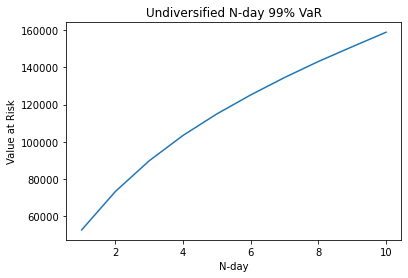

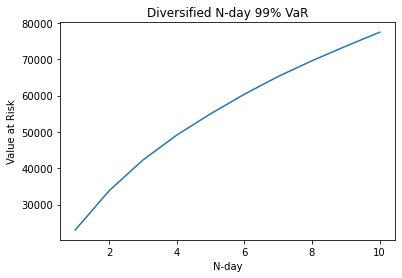

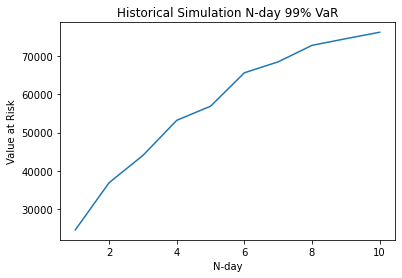

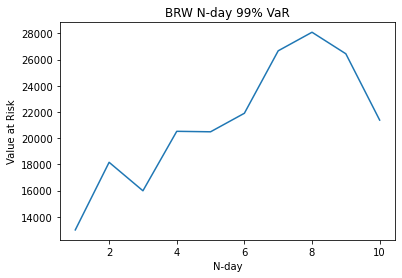

In [19]:
EURUSD = pd.read_csv('https://raw.githubusercontent.com/ateneobsamf2021/ma195l2/main/data/Project1/EURUSD.csv')[:2611]
GBPUSD = pd.read_csv('https://raw.githubusercontent.com/ateneobsamf2021/ma195l2/main/data/Project1/GBPUSD.csv')[:2611]
USDCHF = pd.read_csv('https://raw.githubusercontent.com/ateneobsamf2021/ma195l2/main/data/Project1/USDCHF.csv')[:2611]
USDJPY = pd.read_csv('https://raw.githubusercontent.com/ateneobsamf2021/ma195l2/main/data/Project1/USDJPY.csv')[:2611]
USDPHP = pd.read_csv('https://raw.githubusercontent.com/ateneobsamf2021/ma195l2/main/data/Project1/USDPHP.csv')[:2611]

USD = USDPHP.copy()
EUR = EURUSD.copy()
EUR["Mid"] = EURUSD["Mid"]*USDPHP["Mid"]
JPY = USDJPY.copy()
JPY["Mid"] = USDPHP["Mid"]/USDJPY["Mid"]
GBP = GBPUSD.copy()
GBP["Mid"] = GBPUSD["Mid"]*USDPHP["Mid"]
CHF = USDCHF.copy()
CHF["Mid"] = USDPHP["Mid"]*USDCHF["Mid"]

df_lst = [USD,EUR,JPY,GBP,CHF]
N_lst = [10362,-17135,2235292,-14937,9465]

x = range(1,11)

# Undiversified VaR
y = []
for p in x:
    undiv = undiversified_VaR_delta_normal_fx(df_lst, N_lst, p, 99)
    y.append(undiv)
plt.plot(x,y)
plt.title("Undiversified N-day 99% VaR")
plt.xlabel("N-day")
plt.ylabel("Value at Risk")
plt.show()

# Diversified VaR
y = []
for p in x:
    div = diversified_VaR_delta_normal_fx(df_lst, N_lst, p, 99)
    y.append(div)
plt.plot(x,y)
plt.title("Diversified N-day 99% VaR")
plt.xlabel("N-day")
plt.ylabel("Value at Risk")
plt.show()

# Historical Simulation VaR
y = []
for p in x:
    hs = VaR_hs_fx(df_lst, N_lst, p, 99)
    y.append(hs)
plt.plot(x,y)
plt.title("Historical Simulation N-day 99% VaR")
plt.xlabel("N-day")
plt.ylabel("Value at Risk")
plt.show()

# BRW VaR
y = []
for p in x:
    brw = VaR_brw_fx(df_lst, N_lst, p, 99, 0.85)
    y.append(brw)
plt.plot(x,y)
plt.title("BRW N-day 99% VaR")
plt.xlabel("N-day")
plt.ylabel("Value at Risk")
plt.show()

### Time Window
Based on the graphs below, changing the time window significantly affects the VaR using the Delta-Normal Approach. They now follow an unpredictable pattern. This might be due to large changes in the standard deviation when older data are excluded. 

On the other hand, changing the time window of the Historical Simulation and BRW Approach did not affect the VaR. In both approaches, changing the time window does not affect the results. This might be due to old data are not located at the lower tail of the distribution and having significantly small weight in the BRW approach.

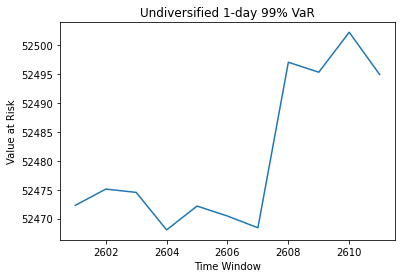

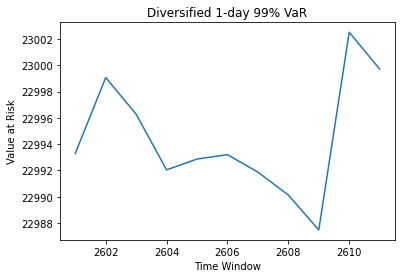

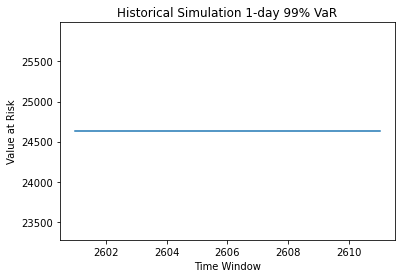

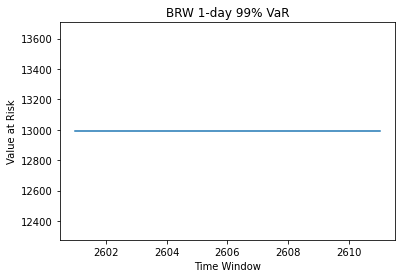

In [20]:
EURUSD = pd.read_csv('https://raw.githubusercontent.com/ateneobsamf2021/ma195l2/main/data/Project1/EURUSD.csv')[:2611]
GBPUSD = pd.read_csv('https://raw.githubusercontent.com/ateneobsamf2021/ma195l2/main/data/Project1/GBPUSD.csv')[:2611]
USDCHF = pd.read_csv('https://raw.githubusercontent.com/ateneobsamf2021/ma195l2/main/data/Project1/USDCHF.csv')[:2611]
USDJPY = pd.read_csv('https://raw.githubusercontent.com/ateneobsamf2021/ma195l2/main/data/Project1/USDJPY.csv')[:2611]
USDPHP = pd.read_csv('https://raw.githubusercontent.com/ateneobsamf2021/ma195l2/main/data/Project1/USDPHP.csv')[:2611]

USD = USDPHP.copy()
EUR = EURUSD.copy()
EUR["Mid"] = EURUSD["Mid"]*USDPHP["Mid"]
JPY = USDJPY.copy()
JPY["Mid"] = USDPHP["Mid"]/USDJPY["Mid"]
GBP = GBPUSD.copy()
GBP["Mid"] = GBPUSD["Mid"]*USDPHP["Mid"]
CHF = USDCHF.copy()
CHF["Mid"] = USDPHP["Mid"]*USDCHF["Mid"]

df_lst = [USD,EUR,JPY,GBP,CHF]
N_lst = [10362,-17135,2235292,-14937,9465]

x = [2611-i for i in range(11)]

# Undiversified VaR
y = []
for p in x:
    new_df_lst = []
    for df in df_lst:
        new_df = df[:p].copy()
        new_df_lst.append(new_df)
        
    undiv = undiversified_VaR_delta_normal_fx(new_df_lst, N_lst, 1, 99)
    y.append(undiv)
plt.plot(x,y)
plt.title("Undiversified 1-day 99% VaR")
plt.xlabel("Time Window")
plt.ylabel("Value at Risk")
plt.show()


# Diversified VaR
y = []
for p in x:
    new_df_lst = []
    for df in df_lst:
        new_df = df[:p].copy()
        new_df_lst.append(new_df)
    
    div = diversified_VaR_delta_normal_fx(new_df_lst, N_lst, 1, 99)
    y.append(div)
plt.plot(x,y)
plt.title("Diversified 1-day 99% VaR")
plt.xlabel("Time Window")
plt.ylabel("Value at Risk")
plt.show()

# Historical Simulation VaR
y = []
for p in x:
    new_df_lst = []
    for df in df_lst:
        new_df = df[:p].copy()
        new_df_lst.append(new_df)
    
    hs = VaR_hs_fx(new_df_lst, N_lst, 1, 99)
    y.append(hs)
plt.plot(x,y)
plt.title("Historical Simulation 1-day 99% VaR")
plt.xlabel("Time Window")
plt.ylabel("Value at Risk")
plt.show()

# BRW VaR
y = []
for p in x:
    new_df_lst = []
    for df in df_lst:
        new_df = df[:p].copy()
        new_df_lst.append(new_df)

    brw = VaR_brw_fx(new_df_lst, N_lst, 1, 99, 0.85)
    y.append(brw)
plt.plot(x,y)
plt.title("BRW 1-day 99% VaR")
plt.xlabel("Time Window")
plt.ylabel("Value at Risk")
plt.show()

### Decay Parameter
Based on the graph below, changing the decay parameter of the BRW Approach does not significantly affect the VaR. A small change in the decay parameter only sightly affects the weight of the returns thus making it relatively predictable and _smooth_.

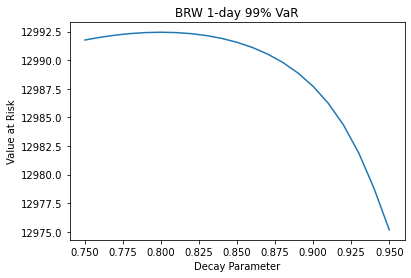

In [21]:
EURUSD = pd.read_csv('https://raw.githubusercontent.com/ateneobsamf2021/ma195l2/main/data/Project1/EURUSD.csv')[:2611]
GBPUSD = pd.read_csv('https://raw.githubusercontent.com/ateneobsamf2021/ma195l2/main/data/Project1/GBPUSD.csv')[:2611]
USDCHF = pd.read_csv('https://raw.githubusercontent.com/ateneobsamf2021/ma195l2/main/data/Project1/USDCHF.csv')[:2611]
USDJPY = pd.read_csv('https://raw.githubusercontent.com/ateneobsamf2021/ma195l2/main/data/Project1/USDJPY.csv')[:2611]
USDPHP = pd.read_csv('https://raw.githubusercontent.com/ateneobsamf2021/ma195l2/main/data/Project1/USDPHP.csv')[:2611]

USD = USDPHP.copy()
EUR = EURUSD.copy()
EUR["Mid"] = EURUSD["Mid"]*USDPHP["Mid"]
JPY = USDJPY.copy()
JPY["Mid"] = USDPHP["Mid"]/USDJPY["Mid"]
GBP = GBPUSD.copy()
GBP["Mid"] = GBPUSD["Mid"]*USDPHP["Mid"]
CHF = USDCHF.copy()
CHF["Mid"] = USDPHP["Mid"]*USDCHF["Mid"]

df_lst = [USD,EUR,JPY,GBP,CHF]
N_lst = [10362,-17135,2235292,-14937,9465]

x = [0.85+i/100 for i in range(-10,11)]

# BRW VaR
y = []
for p in x:
    brw = VaR_brw_fx(df_lst, N_lst, 1, 99, p)
    y.append(brw)
plt.plot(x,y)
plt.title("BRW 1-day 99% VaR")
plt.xlabel("Decay Parameter")
plt.ylabel("Value at Risk")
plt.show()

### Conclusion
Based on the graphs above, the BRW Approach seems to best capture the market risk of the portfolio. 

Looking at the sensitivity analysis on the time window, a change in the time window does not significantly affect the VaR unlike the other methods. This is due to how the BRW weighs the most recent data more than past data. A change in decay parameter also leads to small change in VaR.

However, due to the implementation of the BRW that involves linear interpolation, a change in confidence level might signficantly change the results. Additionally, since the results is based on actual data, a change in the N-day VaR can also result in large differences.

Therefore, as long as the parameters remain constant, the BRW can capture the market risk better than other methods.

## Question B on Bonds
Consider **Portfolio C** and its undiversified 10-day 99% VaR which you calculated using Delta-Normal Approach in Part 2.

Which of the four bonds in the fixed-income portfolio has the highest contribution to the undiversified 10-day 99% VaR? Why? Compare the individual VaRs and determine which factors and bond features led to the bond's high VaR contribution. Explore and discuss the effect of these factors and features to the resulting VaR.

In [22]:
df = pd.read_csv("https://raw.githubusercontent.com/ateneobsamf2021/ma195l2/main/data/Project1/portfolio_c_yield_data.csv")
mat = ["2026-12-31","2022-06-01","2035-01-15","2030-09-28"]
FV = [1000000,1000000,1000000,1000000]
coupon_rate = [0.08,0.075,0.06,0]
coupon_freq = [1,2,4,1]
today="2021-04-23"

for idx in range(len(df.columns)):
    bond = df.columns[idx]
    if bond != "Date":
        tmp_df = df.copy()
        tmp_df.rename({bond:"Yield"},axis=1,inplace=True)
        y = tmp_df["Yield"].iloc[0]/100
        DV01 = get_bond_info(today, mat[idx-1], FV[idx-1], coupon_rate[idx-1], coupon_freq[idx-1], y)[2]
        VaR = undiversified_VaR_delta_normal_bonds([tmp_df], [DV01], 10, 99)
        print(str(bond)+": DV01 - "+str(round(DV01,2))+", VaR - "+str(round(VaR,2)))


Roquefort: DV01 - 484.41, VaR - 11093.89
Camembert: DV01 - 109.67, VaR - 813.88
Feta: DV01 - 923.93, VaR - 20763.78
Gouda: DV01 - 720.2, VaR - 15138.85


Feta has the largest VaR out of the four bonds due to its longer maturity date of January 15, 2035. This means that a small change in yield can have a large effect on the value of the bond since more cash flow are affected by the change in yield. This effect is also compounded (continuously) thus it has a larger impact on the price. In fact, the DV01 of Feta is the largest meaning a 0.01% change in its yield has the greatest change in value.

Gouda has the second largest VaR out of the four bonds since it is a zero rate bond. All of the principal will be returned at maturity so a small change in yield also changes the value by a lot.

Therefore, when comparing the VaR of different types of bonds, longer maturity and zero coupon bonds will have a larger VaR on average, assuming the same par value.